In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
%%capture
%pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
%pip install sentencepiece protobuf datasets huggingface_hub hf_transfer nltk python-Levenshtein
%pip install --no-deps unsloth

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
HUGGINGFACE_TOKEN = user_secrets.get_secret("nlp")

!huggingface-cli login --token $HUGGINGFACE_TOKEN

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
The token `nlp` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `nlp`


In [5]:
from unsloth import FastVisionModel
import torch
import numpy as np
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu
import Levenshtein
import subprocess
import tempfile
import os
from transformers import TextStreamer
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit"
]

In [7]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth"
)

==((====))==  Unsloth 2025.7.11: Fast Qwen2 patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

In [8]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,

    r=16,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    random_state = 3407,
    use_rslora=False,
    loftq_config=None
)

Unsloth: Making `model.base_model.model.model.visual` require gradients


In [10]:
from datasets import load_dataset
dataset = load_dataset("unsloth/Latex_OCR", split="train")

data/train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

In [11]:
split_data = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_data["train"]
temp_dataset = split_data["test"]

# Split temp into eval (10%) and test (10%)
eval_test_split = temp_dataset.train_test_split(test_size=0.5, seed=42)
eval_dataset = eval_test_split["train"]
test_dataset = eval_test_split["test"]

In [12]:
print(f"Train samples: {len(train_dataset)}")
print(f"Eval samples: {len(eval_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 54948
Eval samples: 6869
Test samples: 6869


In [13]:
train_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 54948
})

In [14]:
train_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x40>,
 'text': 'X _ { M } ( m ) = { \\frac { d } { d t } } ( \\exp ( t X ) \\cdot m ) \\Big | _ { t = 0 } .'}

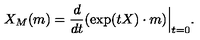

In [15]:
train_dataset[0]["image"]

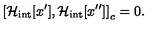

In [16]:
train_dataset[1]["image"]

In [17]:
train_dataset[1]["text"]

'\\left[ { { \\cal H } _ { \\mathrm { i n t } } [ x ^ { \\prime } ] , { \\cal H } _ { \\mathrm { i n t } } [ x ^ { \\prime \\prime } ] } \\right] _ { c } = 0 .'

In [18]:
def exact_match_accuracy(predictions, targets):
    """Calculate percentage of exact matches between predictions and targets"""
    matches = [pred.strip() == target.strip() for pred, target in zip(predictions, targets)]
    return np.mean(matches)

def calculate_bleu_scores(predictions, targets):
    """Calculate BLEU scores for each prediction-target pair"""
    bleu_scores = []
    for pred, target in zip(predictions, targets):
        pred_tokens = pred.strip().split()
        target_tokens = target.strip().split()
        if len(target_tokens) == 0:
            bleu_scores.append(0.0)
        else:
            try:
                score = sentence_bleu([target_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))
                bleu_scores.append(score)
            except:
                bleu_scores.append(0.0)
    return bleu_scores

def calculate_edit_distances(predictions, targets):
    """Calculate edit distances between predictions and targets"""
    distances = []
    for pred, target in zip(predictions, targets):
        distance = Levenshtein.distance(pred.strip(), target.strip())
        distances.append(distance)
    return distances

In [19]:
def check_latex_compilation(latex_code):
    """Check if LaTeX code compiles successfully"""
    latex_document = f"""
    \\documentclass{{article}}
    \\usepackage{{amsmath, amssymb, amsfonts}}
    \\begin{{document}}
    $${latex_code}$$
    \\end{{document}}
    """
    
    try:
        with tempfile.NamedTemporaryFile(mode='w', suffix='.tex', delete=False) as f:
            f.write(latex_document)
            tex_file = f.name
        
        result = subprocess.run(['pdflatex', '-interaction=nonstopmode', tex_file], 
                              capture_output=True, timeout=10, cwd='/tmp')
        
        # Clean up temporary files
        base_name = tex_file[:-4]
        for ext in ['.tex', '.pdf', '.log', '.aux']:
            try:
                os.unlink(base_name + ext)
            except:
                pass
                
        return result.returncode == 0
    except Exception as e:
        return False

def compilation_success_rate(predictions):
    """Calculate percentage of predictions that compile successfully"""
    success_count = sum(check_latex_compilation(pred) for pred in predictions)
    return success_count / len(predictions) if len(predictions) > 0 else 0.0

In [20]:
def evaluate_model(model, tokenizer, eval_dataset, max_samples=None, batch_size=1):
    """Evaluate the model on the evaluation dataset"""
    model.eval()
    predictions = []
    targets = []
    
    # Limit evaluation samples if specified
    samples_to_eval = eval_dataset if max_samples is None else eval_dataset.select(range(min(max_samples, len(eval_dataset))))
    
    instruction = "Write the LaTeX representation for this image."
    
    print(f"Evaluating on {len(samples_to_eval)} samples...")
    
    for i, sample in enumerate(samples_to_eval):
        if i % 10 == 0:
            print(f"Processing sample {i+1}/{len(samples_to_eval)}")
            
        # Prepare input
        messages = [
            {"role": "user", "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]}
            ]}
        ]
        
        input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
        inputs = tokenizer(
            sample["image"], input_text,
            add_special_tokens=False,
            return_tensors="pt",
        ).to("cuda")
        
        # Generate prediction
        with torch.no_grad():
            outputs = model.generate(
                **inputs, 
                max_new_tokens=128, 
                use_cache=True, 
                temperature=0.1,  # Low temperature for consistent evaluation
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )
        
        # Decode prediction
        prediction = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
        prediction = prediction.strip()
        
        predictions.append(prediction)
        targets.append(sample["text"])
    
    # Calculate metrics
    print("Calculating metrics...")
    exact_match = exact_match_accuracy(predictions, targets)
    bleu_scores = calculate_bleu_scores(predictions, targets)
    edit_distances = calculate_edit_distances(predictions, targets)
    
    print("Checking LaTeX compilation (this may take a while)...")
    compilation_rate = compilation_success_rate(predictions)
    
    metrics = {
        "exact_match_accuracy": exact_match,
        "average_bleu": np.mean(bleu_scores),
        "median_bleu": np.median(bleu_scores),
        "std_bleu": np.std(bleu_scores),
        "average_edit_distance": np.mean(edit_distances),
        "median_edit_distance": np.median(edit_distances),
        "std_edit_distance": np.std(edit_distances),
        "compilation_success_rate": compilation_rate,
        "num_samples": len(predictions)
    }
    
    return metrics, predictions, targets

In [21]:
def analyze_errors(predictions, targets, top_k=10):
    """Analyze common error patterns"""
    errors = []
    for pred, target in zip(predictions, targets):
        if pred.strip() != target.strip():
            errors.append({
                'prediction': pred,
                'target': target,
                'edit_distance': Levenshtein.distance(pred, target)
            })
    
    # Sort by edit distance
    errors.sort(key=lambda x: x['edit_distance'], reverse=True)
    
    print(f"\nTop {top_k} most different predictions:")
    for i, error in enumerate(errors[:top_k]):
        print(f"{i+1}. Edit distance: {error['edit_distance']}")
        print(f"   Target: {error['target']}")
        print(f"   Prediction: {error['prediction']}\n")
    
    return errors

In [22]:
instruction = "Write the LaTex representation for this image."

In [23]:
def convert_to_conversation(sample):
  conversation = [
      {"role": "user",
       "content": [
           {"type": "text", "text": instruction},
           {"type": "image", "image": sample["image"]}
       ]
       },
      {"role": "assistant",
       "content": [
           {"type": "text", "text": sample["text"]}
       ]
       }
  ]
  return {"messages": conversation}

In [24]:
converted_train_dataset = [convert_to_conversation(sample) for sample in train_dataset]
converted_eval_dataset = [convert_to_conversation(sample) for sample in eval_dataset]

print("Dataset conversion completed")

Dataset conversion completed


In [26]:
convert_to_conversation(train_dataset[0])

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTex representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'X _ { M } ( m ) = { \\frac { d } { d t } } ( \\exp ( t X ) \\cdot m ) \\Big | _ { t = 0 } .'}]}]}

In [27]:
# converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [28]:
converted_train_dataset[1]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTex representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '\\left[ { { \\cal H } _ { \\mathrm { i n t } } [ x ^ { \\prime } ] , { \\cal H } _ { \\mathrm { i n t } } [ x ^ { \\prime \\prime } ] } \\right] _ { c } = 0 .'}]}]}

In [29]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionSdpaAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=

In [30]:
# Baseline Evaluation (before training)
print("=== BASELINE EVALUATION (BEFORE TRAINING) ===")
FastVisionModel.for_inference(model)
baseline_metrics, baseline_preds, baseline_targets = evaluate_model(
    model, tokenizer, eval_dataset, max_samples=50
)

print("\nBaseline Results:")
for metric, value in baseline_metrics.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

=== BASELINE EVALUATION (BEFORE TRAINING) ===
Evaluating on 50 samples...
Processing sample 1/50
Processing sample 11/50
Processing sample 21/50
Processing sample 31/50
Processing sample 41/50
Calculating metrics...
Checking LaTeX compilation (this may take a while)...

Baseline Results:
exact_match_accuracy: 0.0000
average_bleu: 0.6589
median_bleu: 0.7103
std_bleu: 0.2334
average_edit_distance: 40.1600
median_edit_distance: 23.0000
std_edit_distance: 46.2573
compilation_success_rate: 0.0000
num_samples: 50


In [31]:
image = train_dataset[1]["image"]
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": image}
        ]
    }
]

In [32]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image, input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

In [33]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer= text_streamer, max_new_tokens = 128, use_cache=True, temperature=1.5, min_p=0.1)

$$\left[ \mathcal { H } _ { \mathrm { i n } } ( x ^ { \prime } ) , \mathcal { H } _ { \mathrm { i n } } ( x ^ { \prime \prime } ) \right] _ { \mathrm { c } } = 0 .$$<|im_end|>


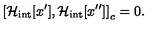

In [34]:
image

In [35]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

In [36]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionSdpaAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=

In [38]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    max_seq_length=2048,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    train_dataset=converted_train_dataset,
    eval_dataset=converted_eval_dataset[:100],  # Limit eval dataset for faster training
    args=SFTConfig(
        per_device_train_batch_size=2,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=100,
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=5,
        eval_steps=25,
        eval_strategy="steps",
        save_steps=50,
        save_total_limit=2,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        dataloader_num_workers=0,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [39]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 54,948 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 50,855,936 of 8,342,231,552 (0.61% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
25,0.129200,0.124244
50,0.102000,0.112220
75,0.125300,0.110495
100,0.113600,0.107174


Unsloth: Not an error, but Qwen2VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=100, training_loss=0.1910795745253563, metrics={'train_runtime': 1249.3267, 'train_samples_per_second': 1.281, 'train_steps_per_second': 0.08, 'total_flos': 1.2502958568026112e+16, 'train_loss': 0.1910795745253563})

In [40]:
print("\n=== POST-TRAINING EVALUATION ===")
FastVisionModel.for_inference(model)


=== POST-TRAINING EVALUATION ===


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionSdpaAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=

In [ ]:
print("Evaluating on validation set...")
val_metrics, val_predictions, val_targets = evaluate_model(
    model, tokenizer, eval_dataset, max_samples=100
)

print("\nValidation Results:")
for metric, value in val_metrics.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

Evaluating on validation set...
Evaluating on 100 samples...
Processing sample 1/100
Processing sample 11/100
Processing sample 21/100
Processing sample 31/100
Processing sample 41/100
Processing sample 51/100
Processing sample 61/100
Processing sample 71/100
Processing sample 81/100
Processing sample 91/100


In [ ]:
print("\nEvaluating on test set...")
test_metrics, test_predictions, test_targets = evaluate_model(
    model, tokenizer, test_dataset, max_samples=100
)

In [ ]:
print("\n=== FINAL TEST SET RESULTS ===")
for metric, value in test_metrics.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

In [ ]:
print("\n=== SAMPLE PREDICTIONS ===")
for i in range(min(5, len(test_predictions))):
    print(f"\nSample {i+1}:")
    print(f"Target:     {test_targets[i]}")
    print(f"Prediction: {test_predictions[i]}")
    match = "✓" if test_targets[i].strip() == test_predictions[i].strip() else "✗"
    print(f"Match: {match}")

In [ ]:
# Error Analysis
print("\n=== ERROR ANALYSIS ===")
errors = analyze_errors(test_predictions, test_targets, top_k=5)

In [ ]:
# Performance Comparison
print("\n=== PERFORMANCE COMPARISON ===")
print("Metric | Baseline | Post-Training | Improvement")
print("-------|----------|---------------|------------")
for metric in baseline_metrics.keys():
    if isinstance(baseline_metrics[metric], float):
        baseline_val = baseline_metrics[metric]
        final_val = test_metrics[metric]
        improvement = final_val - baseline_val
        print(f"{metric} | {baseline_val:.4f} | {final_val:.4f} | {improvement:+.4f}")

In [ ]:
# Interactive Testing Function
def test_single_image(model, tokenizer, image, show_image=True):
    """Test the model on a single image"""
    FastVisionModel.for_inference(model)
    
    instruction = "Write the LaTeX representation for this image."
    messages = [
        {"role": "user", "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": image}
        ]}
    ]
    
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(
        image, input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")
    
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    
    print("Generated LaTeX:")
    with torch.no_grad():
        outputs = model.generate(
            **inputs, 
            streamer=text_streamer, 
            max_new_tokens=128, 
            use_cache=True, 
            temperature=0.1, 
            pad_token_id=tokenizer.eos_token_id
        )
    
    if show_image:
        display(image)
    
    return outputs

In [ ]:
# Test on a sample image
print("\n=== TESTING ON SAMPLE IMAGE ===")
sample_image = test_dataset[0]["image"]
test_single_image(model, tokenizer, sample_image)

print("\n=== TRAINING AND EVALUATION COMPLETED ===")

In [ ]:
image = dataset[2]["image"]

In [ ]:
instruction = "Write the LaTeX representation for this image."

In [ ]:
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

In [ ]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

In [ ]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128, use_cache=True, temperature=1.5, min_p=0.1)

In [ ]:
image